In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.optimize import minimize

In [2]:
# data_address = "correct_data.csv"

In [3]:
data_address = "correct_data.csv"
def data_process(data_address):
    df= pd.read_csv(data_address)
    df= df[['Date', 'BTC', 'LTC', 'XRP', 'DASH', 'RF']]
    df = df.rename(columns={
        'BTC': 'Bitcoin',
        'LTC': 'Litecoin',
        'XRP': 'Ripple',
        'DASH': 'Dash'
    })
    for i in range(1,5):
        df.iloc[:,i]=(df.iloc[:,i]/df.iloc[:,i].shift(1))-1
        # df.iloc[:,i]=np.log(df.iloc[:,i]/df.iloc[:,i].shift(1))
    df=df.drop(df.index[0])

    # "Correlation matrix of the returns of the cryptocurrencies employed in this study"
    corr=df.iloc[:,1:5].corr()
    # "The heatmap"
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    # plt.show()
    return df,corr

In [4]:
df,corr= data_process(data_address)[0],data_process(data_address)[1]
corr

,Bitcoin,Litecoin,Ripple,Dash
Bitcoin,1.000000,0.517376,0.244573,0.245909
Litecoin,0.517376,1.000000,0.558284,0.199640
Ripple,0.244573,0.558284,1.000000,0.050826
Dash,0.245909,0.199640,0.050826,1.000000


In [5]:
df

,Date,Bitcoin,Litecoin,Ripple,Dash,RF
1,2014/2/28,-0.043368,-0.047686,-0.093144,-0.512094,0.001
2,2014/3/7,0.145450,0.198276,0.098233,0.594287,0.001
3,2014/3/14,-0.000556,0.046400,-0.054028,-0.075829,0.001
4,2014/3/21,-0.091142,-0.053566,-0.066777,-0.131502,0.001
5,2014/3/28,-0.132678,-0.124490,-0.203675,-0.010249,0.001
...,...,...,...,...,...,...
215,2018/4/6,-0.036891,-0.045895,-0.065024,-0.082514,0.036
216,2018/4/13,0.189810,0.107808,0.339306,0.236866,0.036
217,2018/4/20,0.120298,0.240782,0.448807,0.304039,0.036
218,2018/4/27,0.015965,-0.061927,-0.119615,0.025295,0.036


## Methodology

1/N model

In [6]:
def equal_weight_model(df):
    num_assets=4
    portfolio_returns = []
    portfolio_returns_1 = []
    for i in range(len(df)):
        weights = np.ones(num_assets) / num_assets
        weekly_returns = df.iloc[i, 1:num_assets + 1].values
        portfolio_return = np.dot(weights, weekly_returns)
        portfolio_return_1 = portfolio_return
        # Not sure
        new_weights= weights*(1+weekly_returns)/sum(weights*(1+weekly_returns))
        # Transaction Cost
        T=50*10**(-4)
        T_1=10**(-3)
        TC=0
        TC_1=0
        for i in range(4):
            TC+=np.abs(new_weights[i]-weights[i])
        TC=TC*T
        TC_1=TC_1*T_1
        # Adjust returns for transaction costs
        portfolio_return -= TC
        portfolio_return_1 -= TC_1
        portfolio_returns.append(portfolio_return)
        portfolio_returns_1.append(portfolio_return_1)
        
    # Create a DataFrame to store the results
    results = pd.DataFrame({'Date': df['Date'], 'Portfolio_Returns': portfolio_returns,
                            'Portfolio_Returns_1': portfolio_returns_1,"RF": df["RF"]})
    results.dropna(inplace=True)
    results["Date"]=pd.to_datetime(results["Date"])
    results.set_index("Date",inplace=True)

    # Sharpe ratio(110-week rolling window. Sh) 
    results["std"]= results["Portfolio_Returns"].rolling(110).std()*np.sqrt(52)
    results["Portfolio_Returns"]=results["Portfolio_Returns"].rolling(110).mean()
    results["std_1"]= results["Portfolio_Returns_1"].rolling(110).std()*np.sqrt(52)
    results["Portfolio_Returns_1"]= results["Portfolio_Returns_1"].rolling(110).mean()
    results["Excess_Returns"]=(results["Portfolio_Returns"]-results["RF"])*52
    results["Excess_Returns_1"]=(results["Portfolio_Returns_1"]-results["RF"])*52
    results["Sharpe_ratio"]= results["Excess_Returns"]/results["std"]
    results["Sharpe_ratio_1"]= results["Excess_Returns_1"]/results["std_1"]

    results.dropna(inplace=True)
    results= results[results.index>=datetime(2016,9,30)]

    return results
results_equal_weight_model= equal_weight_model(df)
# plt.plot(np.array(results_equal_weight_model.index),np.array(results_equal_weight_model["Sharpe_ratio"]))
# plt.title("Sharpe Ratio")
# plt.show()
# plt.plot(np.array(results_equal_weight_model.index),np.array(results_equal_weight_model["std"]))
# plt.title("Portfolio Standard Deviation")
# plt.show()
# plt.plot(np.array(results_equal_weight_model.index),np.array(results_equal_weight_model["Sharpe_ratio_1"]))
# plt.title("Sharpe Ratio after increasing 100% bps")


Markowitz model

In [7]:
def Markowitz_model_weights(df):
    # Define the objective function to minimize (negative Sharpe Ratio).
    def objective_function(weights, expected_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio  # Minimize negative Sharpe ratio

    # Define the constraints: weights sum to 1 and are non-negative.
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # The sum of weights is 1
    bounds = tuple((0, 1) for _ in range(len(df.columns)-2))  # Weights are bound between 0 and 1

    # Initialize a DataFrame to hold the optimal weights at each rebalance.
    optimal_weights_df = pd.DataFrame(index=df["Date"].iloc[109:], columns=df.columns[1:-1])  
    optimal_weights_df_allow_short = pd.DataFrame(index=df["Date"].iloc[109:], columns=df.columns[1:-1]) 

    # Loop over the DataFrame in steps of 110 data points.
    for i in range(109, len(df)):
        # Calculate expected returns and the covariance matrix for the last 110 data points.
        window = df.iloc[i-109:i+1]
        expected_returns = window.iloc[:,1:5].mean()
        cov_matrix = window.iloc[:,1:5].cov()
        risk_free_rate = window['RF'].mean()  # Assuming 'RF' is the risk-free rate

        # Initial guess (equally weighted portfolio).
        initial_guess = [1. / (len(window.columns)-2)] * (len(window.columns)-2)

        # Perform the optimization.
        result = minimize(
            objective_function, 
            initial_guess, 
            args=(expected_returns, cov_matrix, risk_free_rate), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
        )

        result_allow_short=minimize(
            objective_function, 
            initial_guess, 
            args=(expected_returns, cov_matrix, risk_free_rate), 
            method='SLSQP', 
            constraints=constraints
        )
        # Store the optimal weights.
        if result.success:
            optimal_weights_df.iloc[i-109] = result.x
        else:
            optimal_weights_df.iloc[i-109] = np.nan
        
        if result_allow_short.success:
            optimal_weights_df_allow_short.iloc[i-109] = result_allow_short.x
        else:
            optimal_weights_df_allow_short.iloc[i-109] = np.nan
    return optimal_weights_df,optimal_weights_df_allow_short

In [8]:
def Markowitz_model(df,short_type,optimal_weights_df,optimal_weights_df_allow_short):
    '''
    df is the original dataframe
    short_type is a str
    '''
    num_assets =4
    portfolio_returns = []
    portfolio_returns_1 = []
    stds=[]

    if short_type =="no short":
        weights_df= optimal_weights_df
    elif short_type =="allow short":
        weights_df= optimal_weights_df_allow_short 

    for i in range(1,len(weights_df)):
        weights = weights_df.iloc[i].values
        # rolling_return
        rolling_df=df.iloc[i:110+i, 1:num_assets + 1].rolling(110).mean()
        weekly_returns = rolling_df.iloc[-1].values
        
        cov_matrix=df.iloc[i:110+i, 1:num_assets + 1].cov()
        std=np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*10
        stds.append(std)
        
        portfolio_return = np.dot(weights, weekly_returns)
        portfolio_return_1 = portfolio_return
        previous_weights= weights_df.iloc[i-1].values
        # Transaction Cost
        T=50*10**(-4)
        T_1=10**(-3)
        TC=0
        TC_1=0
        for i in range(4):
            TC+=np.abs(weights[i]-previous_weights[i])
        TC=TC*T
        TC_1=TC_1*T_1
        # Adjust returns for transaction costs
        portfolio_return -= TC
        portfolio_return_1 -= TC_1
        portfolio_returns.append(portfolio_return)
        portfolio_returns_1.append(portfolio_return_1)
    
    # Create a DataFrame to store the results
    results = pd.DataFrame({'Date': df['Date'].iloc[110:], 'Portfolio_Returns': portfolio_returns,"Standard_deviation":stds,
                        'Portfolio_Returns_1': portfolio_returns_1,"RF": df["RF"].iloc[110:]})
    results.dropna(inplace=True)
    results["Date"]=pd.to_datetime(results["Date"])
    results.set_index("Date",inplace=True)
    results["Excess_Returns"]=(results["Portfolio_Returns"]-results["RF"])*52
    results["Excess_Returns_1"]=(results["Portfolio_Returns_1"]-results["RF"])*52
    results["Standard_deviation"]=results["Standard_deviation"]
    results["Sharpe_ratio"]= results["Excess_Returns"]/results["Standard_deviation"]
    results["Sharpe_ratio_1"]= results["Excess_Returns_1"]/results["Standard_deviation"]

    results.dropna(inplace=True)
    results= results[results.index>=datetime(2016,9,30)]

    '''
    Sharpe_ratio is the SR with 50bps transcation cost
    Sharpe_ratio_1 is the SR with 100bps transcation cost
    '''
    return results

optimal_weights_df, optimal_weights_df_allow_short= Markowitz_model_weights(df)[0],Markowitz_model_weights(df)[1]
results_Markowitz_model= Markowitz_model(df,"no short",optimal_weights_df,optimal_weights_df_allow_short)
results_Markowitz_model_allow_short=Markowitz_model(df,"allow short",optimal_weights_df,optimal_weights_df_allow_short)
# plt.plot(np.array(results_Markowitz_model.index),np.array(results_Markowitz_model["Sharpe_ratio"]))
# plt.title("Sharpe Ratio")
# plt.show()
# plt.plot(np.array(results_Markowitz_model.index),np.array(results_Markowitz_model["Standard_deviation"]))
# plt.title("Portfolio Standard Deviation")
# plt.show()
# plt.plot(np.array(results_Markowitz_model.index),np.array(results_Markowitz_model["Sharpe_ratio_1"]))
# plt.title("Sharpe Ratio after increasing 100% bps")


In [9]:
results_equal_weight_model

,Portfolio_Returns,Portfolio_Returns_1,RF,std,std_1,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,,
2016-09-30,0.011249,0.011580,0.005,0.596807,0.597779,0.324959,0.342175,0.544496,0.572411
2016-10-07,0.011328,0.011659,0.004,0.596408,0.597384,0.381069,0.398255,0.638939,0.666666
2016-10-14,0.011887,0.012217,0.004,0.596845,0.597819,0.410113,0.427308,0.687136,0.714779
2016-10-21,0.011626,0.011957,0.004,0.597194,0.598172,0.396566,0.413740,0.664048,0.691673
2016-10-28,0.011614,0.011941,0.004,0.597241,0.598229,0.395907,0.412939,0.662893,0.690270
...,...,...,...,...,...,...,...,...,...
2018-04-06,0.050436,0.050842,0.036,1.100180,1.102106,0.750691,0.771775,0.682334,0.700273
2018-04-13,0.052252,0.052657,0.036,1.105964,1.107871,0.845105,0.866151,0.764134,0.781816
2018-04-20,0.054175,0.054582,0.036,1.116780,1.118667,0.945086,0.966240,0.846260,0.863742


In [10]:
results_Markowitz_model

,Portfolio_Returns,Standard_deviation,Portfolio_Returns_1,RF,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,
2016-09-30,0.019535,1.114295,0.019695,0.005,0.755842,0.764150,0.678314,0.685770
2016-10-07,0.020231,1.119603,0.020665,0.004,0.844017,0.866580,0.753854,0.774007
2016-10-14,0.019726,1.106653,0.020123,0.004,0.817743,0.838410,0.738933,0.757609
2016-10-21,0.019671,1.104968,0.019828,0.004,0.814914,0.823068,0.737499,0.744879
2016-10-28,0.012185,0.915279,0.014790,0.004,0.425642,0.561088,0.465040,0.613024
...,...,...,...,...,...,...,...,...
2018-04-06,0.049077,1.295381,0.049181,0.036,0.680010,0.685406,0.524949,0.529115
2018-04-13,0.049836,1.284789,0.050143,0.036,0.719479,0.735438,0.559998,0.572419
2018-04-20,0.051955,1.305246,0.051990,0.036,0.829651,0.831461,0.635628,0.637015


In [11]:
results_Markowitz_model_allow_short

,Portfolio_Returns,Standard_deviation,Portfolio_Returns_1,RF,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,
2016-09-30,0.022509,1.347752,0.023722,0.005,0.910443,0.973551,0.675527,0.722351
2016-10-07,0.023951,1.345982,0.024774,0.004,1.037443,1.080236,0.770770,0.802564
2016-10-14,0.020977,1.226109,0.022232,0.004,0.882785,0.948073,0.719989,0.773237
2016-10-21,0.021355,1.243139,0.022369,0.004,0.902466,0.955183,0.725957,0.768363
2016-10-28,0.011523,0.944829,0.015404,0.004,0.391182,0.593009,0.414024,0.627636
...,...,...,...,...,...,...,...,...
2018-04-06,0.049042,1.293018,0.049162,0.036,0.678169,0.684433,0.524485,0.529330
2018-04-13,0.049821,1.283462,0.050171,0.036,0.718696,0.736906,0.559967,0.574155
2018-04-20,0.051979,1.304018,0.052018,0.036,0.830925,0.832962,0.637204,0.638766


Results

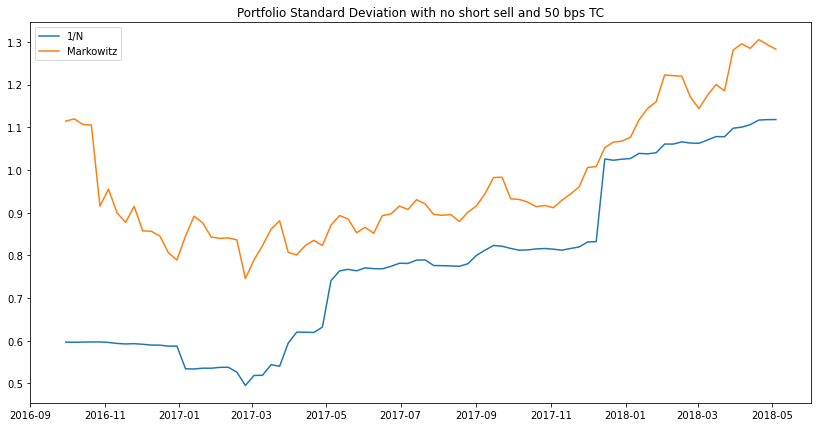

In [12]:
# Portfolio std with no short sell and 50 bps transcation cost
plt.figure(figsize=(14, 7))

plt.plot(np.array(results_equal_weight_model.index), np.array(results_equal_weight_model['std']), label='1/N')
plt.plot(np.array(results_Markowitz_model.index), np.array(results_Markowitz_model['Standard_deviation']), label='Markowitz')

plt.title('Portfolio Standard Deviation with no short sell and 50 bps TC')
plt.legend()

plt.show()

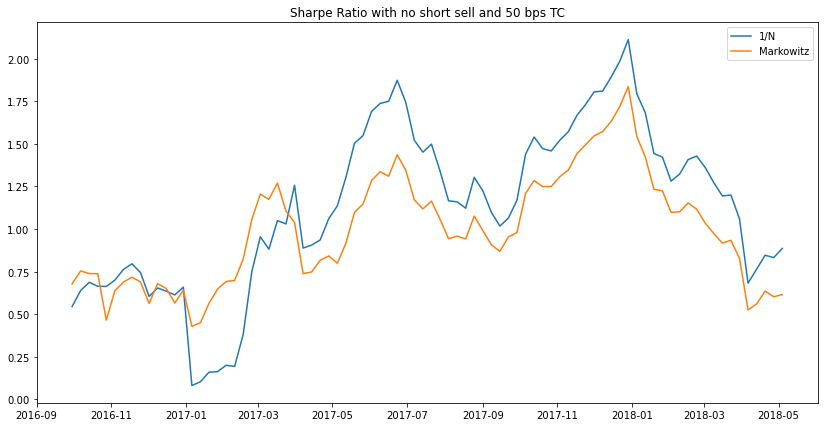

In [13]:
# Sharpe Ratio with no short_sell and 50 bps transcation cost
plt.figure(figsize=(14, 7))
plt.plot(np.array(results_equal_weight_model.index), np.array(results_equal_weight_model['Sharpe_ratio']), label='1/N')
plt.plot(np.array(results_Markowitz_model.index), np.array(results_Markowitz_model['Sharpe_ratio']), label='Markowitz')
plt.title('Sharpe Ratio with no short sell and 50 bps TC')
plt.legend()
plt.show()


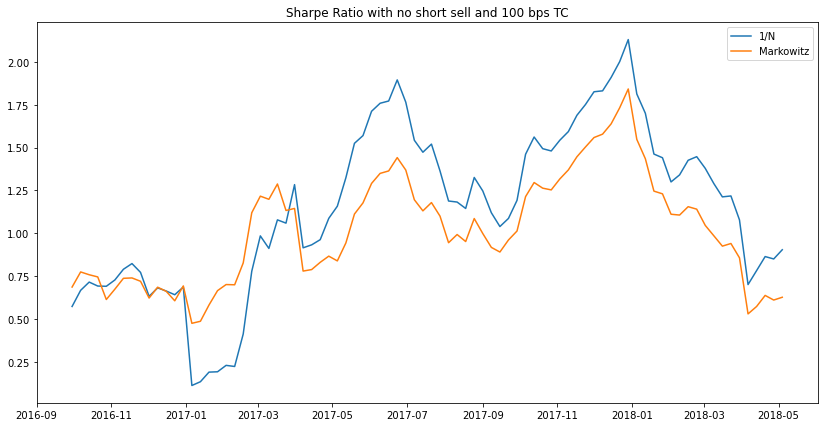

In [14]:
# Sharpe Ratio with no short_sell and 100 bps transcation cost
plt.figure(figsize=(14, 7))
plt.plot(np.array(results_equal_weight_model.index), np.array(results_equal_weight_model['Sharpe_ratio_1']), label='1/N')
plt.plot(np.array(results_Markowitz_model.index), np.array(results_Markowitz_model['Sharpe_ratio_1']), label='Markowitz')
plt.title('Sharpe Ratio with no short sell and 100 bps TC')
plt.legend()
plt.show()

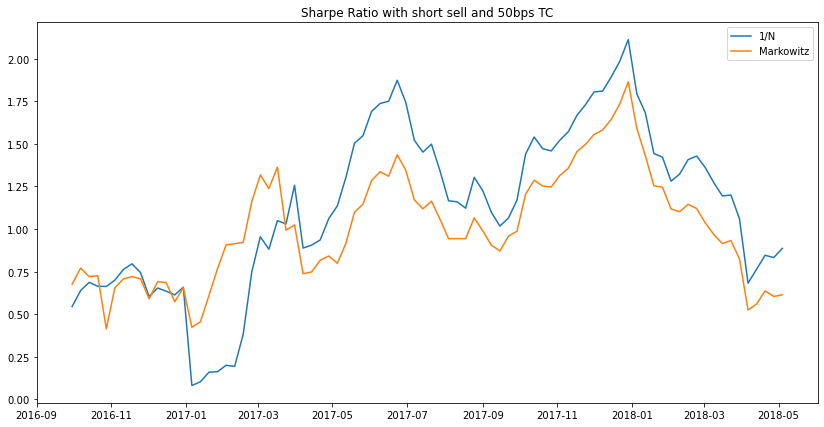

In [15]:
# Sharpe Ratio with short_sell and 50 bps transcation cost
plt.figure(figsize=(14, 7))
plt.plot(np.array(results_equal_weight_model.index), np.array(results_equal_weight_model['Sharpe_ratio']), label='1/N')
plt.plot(np.array(results_Markowitz_model.index), np.array(results_Markowitz_model_allow_short['Sharpe_ratio']), label='Markowitz')
plt.title('Sharpe Ratio with short sell and 50bps TC')
plt.legend()
plt.show()

In [16]:
results_equal_weight_model
results_Markowitz_model
results_Markowitz_model_allow_short

,Portfolio_Returns,Standard_deviation,Portfolio_Returns_1,RF,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,
2016-09-30,0.022509,1.347752,0.023722,0.005,0.910443,0.973551,0.675527,0.722351
2016-10-07,0.023951,1.345982,0.024774,0.004,1.037443,1.080236,0.770770,0.802564
2016-10-14,0.020977,1.226109,0.022232,0.004,0.882785,0.948073,0.719989,0.773237
2016-10-21,0.021355,1.243139,0.022369,0.004,0.902466,0.955183,0.725957,0.768363
2016-10-28,0.011523,0.944829,0.015404,0.004,0.391182,0.593009,0.414024,0.627636
...,...,...,...,...,...,...,...,...
2018-04-06,0.049042,1.293018,0.049162,0.036,0.678169,0.684433,0.524485,0.529330
2018-04-13,0.049821,1.283462,0.050171,0.036,0.718696,0.736906,0.559967,0.574155
2018-04-20,0.051979,1.304018,0.052018,0.036,0.830925,0.832962,0.637204,0.638766


In [17]:
results_equal_weight_model

,Portfolio_Returns,Portfolio_Returns_1,RF,std,std_1,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,,
2016-09-30,0.011249,0.011580,0.005,0.596807,0.597779,0.324959,0.342175,0.544496,0.572411
2016-10-07,0.011328,0.011659,0.004,0.596408,0.597384,0.381069,0.398255,0.638939,0.666666
2016-10-14,0.011887,0.012217,0.004,0.596845,0.597819,0.410113,0.427308,0.687136,0.714779
2016-10-21,0.011626,0.011957,0.004,0.597194,0.598172,0.396566,0.413740,0.664048,0.691673
2016-10-28,0.011614,0.011941,0.004,0.597241,0.598229,0.395907,0.412939,0.662893,0.690270
...,...,...,...,...,...,...,...,...,...
2018-04-06,0.050436,0.050842,0.036,1.100180,1.102106,0.750691,0.771775,0.682334,0.700273
2018-04-13,0.052252,0.052657,0.036,1.105964,1.107871,0.845105,0.866151,0.764134,0.781816
2018-04-20,0.054175,0.054582,0.036,1.116780,1.118667,0.945086,0.966240,0.846260,0.863742


In [18]:
results_Markowitz_model

,Portfolio_Returns,Standard_deviation,Portfolio_Returns_1,RF,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,
2016-09-30,0.019535,1.114295,0.019695,0.005,0.755842,0.764150,0.678314,0.685770
2016-10-07,0.020231,1.119603,0.020665,0.004,0.844017,0.866580,0.753854,0.774007
2016-10-14,0.019726,1.106653,0.020123,0.004,0.817743,0.838410,0.738933,0.757609
2016-10-21,0.019671,1.104968,0.019828,0.004,0.814914,0.823068,0.737499,0.744879
2016-10-28,0.012185,0.915279,0.014790,0.004,0.425642,0.561088,0.465040,0.613024
...,...,...,...,...,...,...,...,...
2018-04-06,0.049077,1.295381,0.049181,0.036,0.680010,0.685406,0.524949,0.529115
2018-04-13,0.049836,1.284789,0.050143,0.036,0.719479,0.735438,0.559998,0.572419
2018-04-20,0.051955,1.305246,0.051990,0.036,0.829651,0.831461,0.635628,0.637015


In [19]:
results_Markowitz_model_allow_short

,Portfolio_Returns,Standard_deviation,Portfolio_Returns_1,RF,Excess_Returns,Excess_Returns_1,Sharpe_ratio,Sharpe_ratio_1
Date,,,,,,,,
2016-09-30,0.022509,1.347752,0.023722,0.005,0.910443,0.973551,0.675527,0.722351
2016-10-07,0.023951,1.345982,0.024774,0.004,1.037443,1.080236,0.770770,0.802564
2016-10-14,0.020977,1.226109,0.022232,0.004,0.882785,0.948073,0.719989,0.773237
2016-10-21,0.021355,1.243139,0.022369,0.004,0.902466,0.955183,0.725957,0.768363
2016-10-28,0.011523,0.944829,0.015404,0.004,0.391182,0.593009,0.414024,0.627636
...,...,...,...,...,...,...,...,...
2018-04-06,0.049042,1.293018,0.049162,0.036,0.678169,0.684433,0.524485,0.529330
2018-04-13,0.049821,1.283462,0.050171,0.036,0.718696,0.736906,0.559967,0.574155
2018-04-20,0.051979,1.304018,0.052018,0.036,0.830925,0.832962,0.637204,0.638766


In [20]:
Results_Zizheng = results_equal_weight_model[["std","Sharpe_ratio","Sharpe_ratio_1"]]
Results_Zizheng = Results_Zizheng.rename(columns={
    "std":"std_1/N_model",
    "Sharpe_ratio":"SR_1/N_model_50bps",
    "Sharpe_ratio_1":"SR_1/N_model_100bps"
})
Results_1=pd.merge(Results_Zizheng,results_Markowitz_model[["Standard_deviation","Sharpe_ratio","Sharpe_ratio_1"]],on=Results_Zizheng.index)
Results_1 = Results_1.rename(columns={
    "Standard_deviation":"std_Markowitz_model",
    "Sharpe_ratio":"SR_Markowitz_model_50bps_noshort",
    "Sharpe_ratio_1":"SR_Markowitz_model_100bps_noshort"
})
Results_1=Results_1.set_index("key_0")
Results_1.index
Results_2=pd.merge(Results_1,results_Markowitz_model_allow_short[["Sharpe_ratio","Sharpe_ratio_1"]],on=Results_1.index)
Results_2.set_index("key_0",inplace=True)
Results = Results_2.rename(columns={
    "Sharpe_ratio":"SR_Markowitz_model_50bps_short",
    "Sharpe_ratio_1":"SR_Markowitz_model_100bps_short"
})

In [21]:
Results.index.name="Date"

In [22]:
Results.to_csv("Results.csv")